### 1. LeNet5 Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np

class ScaledTanh(nn.Module):
    def forward(self, x):
        return 1.7159 * torch.tanh(x * 2 / 3)
    
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.tanh = ScaledTanh()

        # C1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        
        # S2
        self.weight2 = nn.Parameter(torch.ones(1, 6, 1, 1))
        self.bias2 = nn.Parameter(torch.zeros(1, 6, 1, 1))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight2)
        nn.init.uniform_(self.weight2, -2.4 / fan_in, 2.4 / fan_in)
        self.bias2.data.fill_(2.4 / fan_in)

        # C3
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        mask = torch.zeros_like(self.conv3.weight, dtype=torch.bool)
        table = self.connection_table()
        for out_idx, conn in enumerate(table):
            mask[out_idx, conn] = True
        self.register_buffer("conv3_mask", mask.float())
        with torch.no_grad():
            self.conv3.weight *= self.conv3_mask

        # S4
        self.weight4 = nn.Parameter(torch.ones(1, 16, 1, 1))
        self.bias4 = nn.Parameter(torch.zeros(1, 16, 1, 1))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight4)
        nn.init.uniform_(self.weight4, -2.4 / fan_in, 2.4 / fan_in)
        self.bias4.data.fill_(2.4 / fan_in)

        # C5
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)

        # F6
        self.fc6 = nn.Linear(120, 84)

        # Output Layer
        self.prototypes = self.compute_rbf_prototypes()

    def connection_table(self):
        return [
            [0, 1, 2],
            [1, 2, 3],
            [2, 3, 4],
            [3, 4, 5],
            [0, 4, 5],
            [0, 1, 5],
            [0, 1, 2, 3],
            [1, 2, 3, 4],
            [2, 3, 4, 5],
            [0, 3, 4, 5],
            [0, 1, 4, 5],
            [0, 1, 2, 5],
            [0, 1, 3, 4],
            [1, 2, 4, 5],
            [1, 2, 3, 5],
            [0, 1, 2, 3, 4, 5]
        ]

    def compute_rbf_prototypes(self):
        import matplotlib.pyplot as plt

        prototypes = []

        image_folder = './digits updated/'
        bitmap_size = (7,12)
        num_classes = 10

        for label in range(num_classes):
            class_folder = os.path.join(image_folder, str(label))
            images = []
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                image = cv2.imread(img_path, 0)
                if image is not None:
                    image = cv2.resize(image, bitmap_size)
                    image = 255.0 - image  # Invert colors
                    image = (image > 127).astype(np.float32)  # Binarize to 0 and 1
                    image = image / 255.0

                    images.append(image)
            if images:
                mean_image = np.mean(images, axis=0)
                prototypes.append(mean_image.flatten())

        prototypes_arr = np.array(prototypes)

        return torch.tensor(prototypes_arr, dtype=torch.float32)

    def compute_rbf_distance(self, x):
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-5)
        prototypes = (self.prototypes - self.prototypes.mean(dim=1, keepdim=True)) / (self.prototypes.std(dim=1, keepdim=True) + 1e-5)

        # L2 normalize input features and prototypes
        x = F.normalize(x, p=2, dim=1)  # shape: [batch_size, feature_dim]
        prototypes = F.normalize(prototypes, p=2, dim=1)  # shape: [num_classes, feature_dim]

        # Compute pairwise squared Euclidean distances
        x_expanded = x.unsqueeze(1)  # shape: [batch_size, 1, feature_dim]
        prototypes_expanded = prototypes.unsqueeze(0)  # shape: [1, num_classes, feature_dim]
        output = (x_expanded - prototypes_expanded).pow(2).sum(-1)  # shape: [batch_size, num_classes]

        return output   

    def forward(self, x):
        # C1
        x = self.conv1(x)
        x = self.tanh(x)

        # S2
        x = F.avg_pool2d(x, kernel_size=2, stride=2) * self.weight2.view(1, -1, 1, 1) + self.bias2.view(1, -1, 1, 1)
        x = self.tanh(x)

        # C3
        self.conv3.weight.data *= self.conv3_mask  # Apply the mask to the weights
        x = self.conv3(x)
        x = self.tanh(x)

        # S4
        x = F.avg_pool2d(x, kernel_size=2, stride=2) * self.weight4.view(1, -1, 1, 1) + self.bias4.view(1, -1, 1, 1)
        x = self.tanh(x)

        # C5
        x = self.conv5(x)
        x = self.tanh(x)

        # F6
        x = x.view(x.size(0), -1)
        x = self.fc6(x)

        # Output Layer
        x = self.compute_rbf_distance(x)
        return x

### 2. Load Train and Test Data

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
train_image_folder = './data/train/'
test_image_folder = './data/test/'
train_label_file = './data/train_label.txt'
test_label_file = './data/test_label.txt'

train_images = []
train_labels = []
test_images = []
test_labels = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

with open(train_label_file, 'r') as f:
    label_lines = f.readlines()
    image_filenames = sorted(os.listdir(train_image_folder))

    for idx in range(len(label_lines)):
        img_name = f"{idx}.png"
        img_path = os.path.join(train_image_folder, img_name)
        img = cv2.imread(img_path, 0)
        if img is not None:
            image = Image.fromarray(img)
            image = transform(image)
            train_images.append(image)
            label = int(label_lines[idx].strip())
            train_labels.append(label)

with open(test_label_file, 'r') as f:
    label_lines = f.readlines()
    image_filenames = sorted(os.listdir(train_image_folder))

    for idx in range(len(label_lines)):
        img_name = f"{idx}.png"
        img_path = os.path.join(test_image_folder, img_name)
        img = cv2.imread(img_path, 0)
        if img is not None:
            image = Image.fromarray(img)
            image = transform(image)
            test_images.append(image)
            label = int(label_lines[idx].strip())
            test_labels.append(label)

train_images = torch.stack(train_images)
test_images = torch.stack(test_images)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [ ]:
train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=1, shuffle=False)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=1, shuffle=False)

### 3. Train the Model

In [ ]:
def customLoss(outputs, labels, j=0.1):
    batch_size = outputs.size(0)

    # Correct class distances
    pos_dists = outputs[torch.arange(batch_size), labels]  # Shape: [B]

    # Mask out correct class
    mask = torch.ones_like(outputs, dtype=torch.bool)
    mask[torch.arange(batch_size), labels] = False
    neg_dists = outputs[mask].view(batch_size, -1)  # Shape: [B, C-1]

    # Stable discriminative log-sum-exp term
    # log(e^{-j} + sum(e^{-d_i})) = logsumexp([-j, -d1, -d2, ..., -d9])
    margin_tensor = torch.full((batch_size, 1), -j, device=outputs.device)
    all_terms = torch.cat([margin_tensor, -neg_dists], dim=1)
    log_term = torch.logsumexp(all_terms, dim=1)

    # Final loss (lower distance is better)
    loss = (-pos_dists + log_term).mean()
    return loss

In [186]:
from tqdm import tqdm

# Define relevant variables
num_classes = 10
learning_rate = 0.001
num_epochs = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5(num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

# Initialize lists to store accuracy and error rates for plotting
train_accuracy_list = []
test_accuracy_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = customLoss(outputs, labels)
        train_loss_list.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total


    # After training the epoch, evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    test_loss = 0

    with torch.no_grad():  # No gradient tracking during evaluation
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = customLoss(outputs, labels)
            test_loss_list.append(loss.item())

            # Compute the accuracy
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Testing accuracy and error rate for the epoch
    test_accuracy = 100 * test_correct / test_total

    # Print the results for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Accuracy: {train_accuracy:.2f}%, '
          f'Testing Accuracy: {test_accuracy:.2f}%, ')


    # Store values for plotting later
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)


Epoch [1/20], Training Accuracy: 20.05%, Testing Accuracy: 60.81%


Epoch [2/20], Training Accuracy: 73.70%, Testing Accuracy: 75.60%


Epoch [3/20], Training Accuracy: 80.46%, Testing Accuracy: 82.03%


Epoch [4/20], Training Accuracy: 85.96%, Testing Accuracy: 88.37%


Epoch [5/20], Training Accuracy: 90.33%, Testing Accuracy: 90.79%


Epoch [6/20], Training Accuracy: 92.02%, Testing Accuracy: 91.82%


Epoch [7/20], Training Accuracy: 92.93%, Testing Accuracy: 92.63%


Epoch [8/20], Training Accuracy: 93.47%, Testing Accuracy: 93.17%


Epoch [9/20], Training Accuracy: 93.92%, Testing Accuracy: 93.56%


Epoch [10/20], Training Accuracy: 94.26%, Testing Accuracy: 93.94%


Epoch [11/20], Training Accuracy: 94.51%, Testing Accuracy: 94.29%


Epoch [12/20], Training Accuracy: 94.73%, Testing Accuracy: 94.41%


Epoch [13/20], Training Accuracy: 94.92%, Testing Accuracy: 94.64%


Epoch [14/20], Training Accuracy: 95.11%, Testing Accuracy: 94.83%


Epoch [15/20], Training Accuracy: 95.31%, Testing Accuracy: 95.01%


Epoch [16/20], Training Accuracy: 95.48%, Testing Accuracy: 95.30%


Epoch [17/20], Training Accuracy: 95.64%, Testing Accuracy: 95.56%


Epoch [18/20], Training Accuracy: 95.79%, Testing Accuracy: 95.78%


Epoch [19/20], Training Accuracy: 95.95%, Testing Accuracy: 95.96%


Epoch [20/20], Training Accuracy: 96.07%, Testing Accuracy: 96.07%


In [ ]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for efficiency
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

### 4. Evaluate the Results

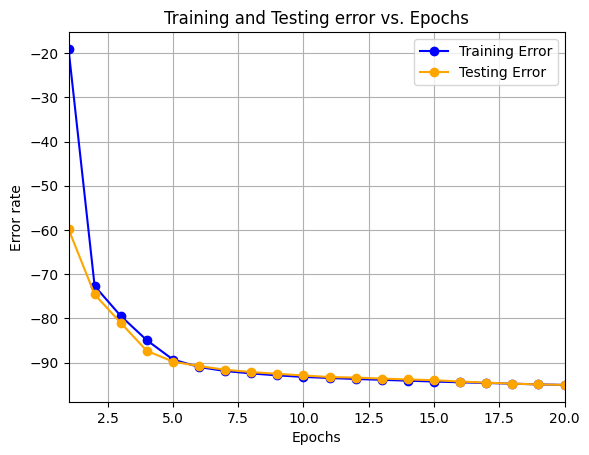

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.plot(epochs, [1 - acc for acc in train_accuracy_list], label='Training Error', marker='o', color = "blue")
plt.plot(epochs, [1 - acc for acc in test_accuracy_list], label='Testing Error', marker='o', color = "orange")
plt.title("Training and Testing error vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error rate")
plt.xlim(1,num_epochs)
plt.grid()
plt.legend()

(10000,) (10000,)


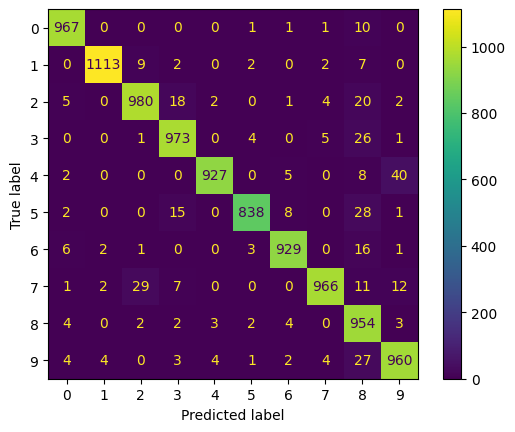

In [192]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds = []
y_labels = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)        
        y_pred = model(data)        
        _, predicted_labels = torch.max(y_pred, dim=1)
        y_preds.append(predicted_labels.cpu().numpy())  
        y_labels.append(target.cpu().numpy()) 
y_preds = np.concatenate(y_preds)
y_labels = np.concatenate(y_labels)
print(y_preds.shape, y_labels.shape)
cm = confusion_matrix(y_labels, y_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Using device: cpu


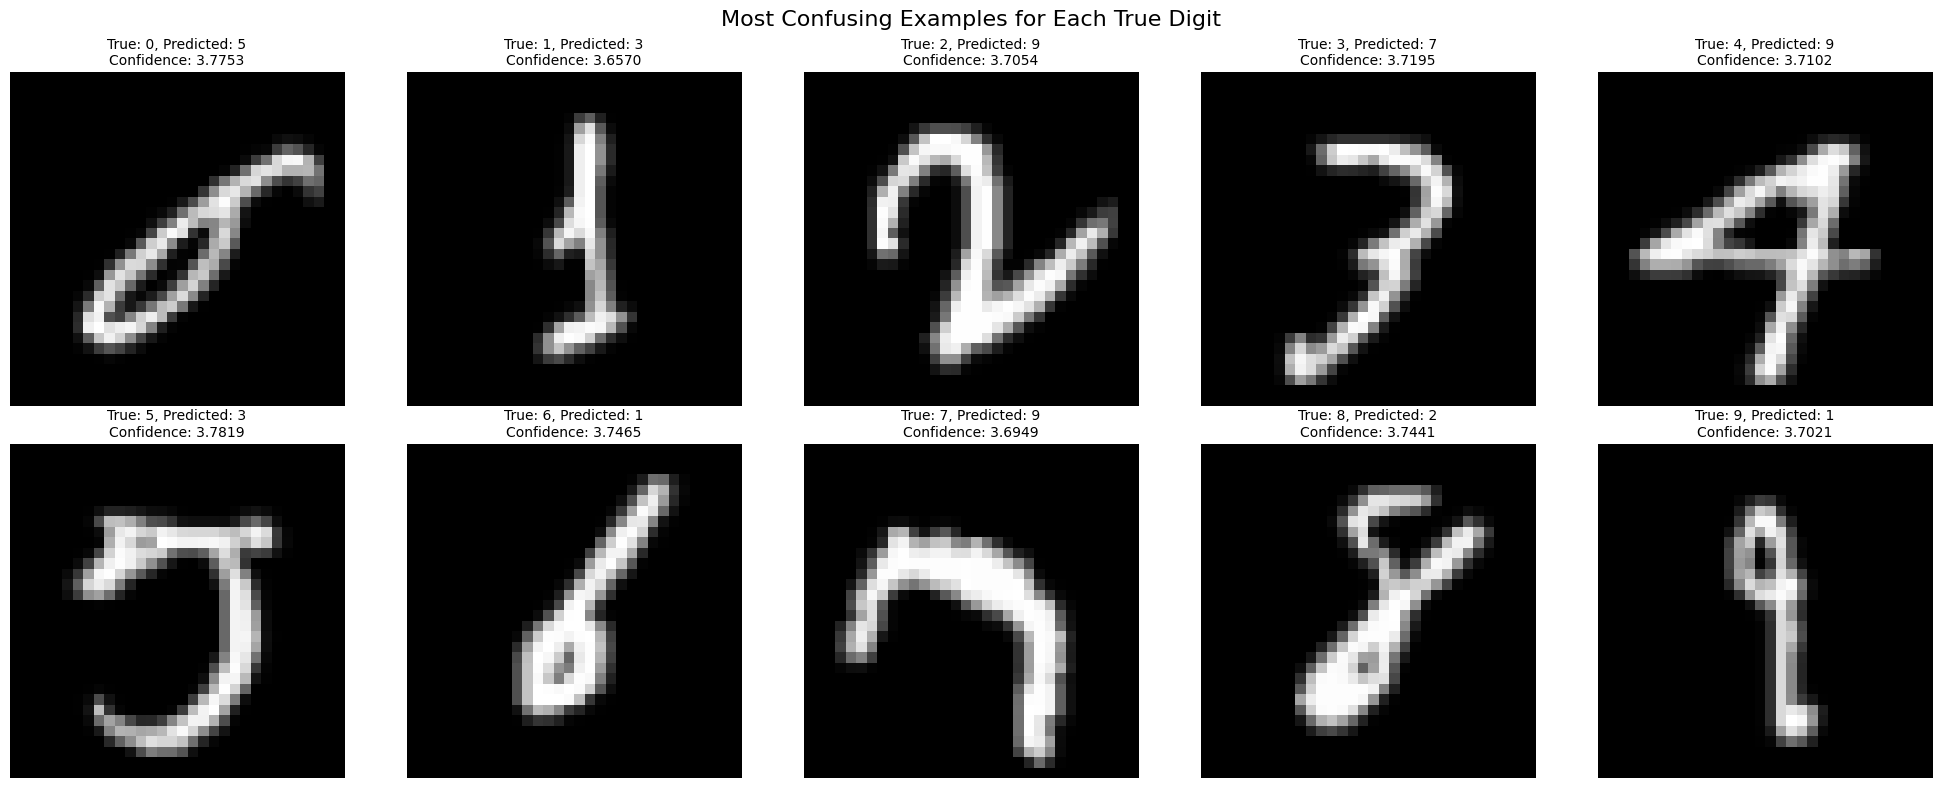

In [194]:
def find_most_confusing_examples(model, test_loader, device):
    model.eval()
    most_confusing = {
        digit: {
            'min_confidence': float('inf'),
            'image': None,
            'true_label': digit,
            'predicted_label': None,
            'rbf_values': None
        } for digit in range(10)
    }

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)  # or torch.max, depending on RBF layer design

            for i in range(len(labels)):
                true_label = labels[i].item()
                predicted_label = predicted[i].item()

                if true_label != predicted_label:
                    rbf_values = outputs[i]
                    confidence = rbf_values[predicted_label].item()

                    # Store the most confidently wrong prediction *for the true label*
                    if confidence < most_confusing[true_label]['min_confidence']:
                        most_confusing[true_label] = {
                            'min_confidence': confidence,
                            'image': images[i].cpu(),
                            'true_label': true_label,
                            'predicted_label': predicted_label,
                            'rbf_values': rbf_values.cpu()
                        }

    return most_confusing

def visualize_confusing_examples(most_confusing):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Most Confusing Examples for Each True Digit', fontsize=16)
    for digit in range(10):
        row = digit // 5
        col = digit % 5
        conf_example = most_confusing[digit]
        if conf_example['image'] is not None:
            axs[row, col].imshow(conf_example['image'].squeeze(), cmap='gray')
            axs[row, col].set_title(
                f'True: {digit}, Predicted: {conf_example["predicted_label"]}\n' +
                f'Confidence: {conf_example["min_confidence"]:.4f}',
                fontsize=10
            )
        else:
            axs[row, col].set_title(f'No Misclassifications\nTrue: {digit}', fontsize=10)
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

most_confusing_examples = find_most_confusing_examples(model, test_loader, device)
visualize_confusing_examples(most_confusing_examples)

In [ ]:
print('Train Accuracy at epoch', num_epochs, ': ',train_accuracy_list[num_epochs-1])
print('Test Accuracy at epoch', num_epochs, ': ',test_accuracy_list[num_epochs-1])

Train Accuracy at epoch 20 :  96.07333333333334
Test Accuracy at epoch 20 :  96.07


### 5. Save the Model

In [ ]:
torch.save(model.state_dict(), 'LeNet1.pth')